# Introduction

We are looking to create a predictive model that can classify what type of hand you have given 5 cards and their respective suit.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Google Drive mount

This will mount the Google drive to colab


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Here assuming the all data of poker from https://github.com/bhaskar-debug/poker/tree/main is copied in google drive inside `MyDrive/poker`


In [3]:
root = "/content/drive/MyDrive/poker/content"
data_path = f"{root}/data"

# Step 1

Step one with any data is to import it.

Below we have the statement that is importing the data which is of file extension ".data". Please note that the program is reading line by line and therefore must make appropriate type conversions.


In [4]:
df_hands_train = pd.read_csv(
    f"{data_path}/raw/poker-hand-training-true.data",
    names=["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand Rank"],
)
df_hands_train.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand Rank
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


#### TODO:// I have used small dataset above to train, please uncomment the following below to train with larger datasets.


In [ ]:
# TODO:// Uncomment this to use the 10M dataset

# df_hands_train = pd.read_csv(
#     f"{data_path}/raw/poker10m",
#     names=["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand Rank"],
# )
# df_hands_train.head()

In [5]:
df_hands_test = pd.read_csv(
    f"{data_path}/raw/poker-hand-testing.data",
    names=["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand Rank"],
)
df_hands_test.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand Rank
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


# Step 2


We take that DataFrame and we split it into the training data.

- X_train is all the lines except the classification of the hand.
- Y_train is the given hand classification.


In [6]:
X_train = df_hands_train.iloc[:, :-1].reset_index(drop=True)
y_train = df_hands_train.iloc[:, -1]
X_train.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,1,10,1,11,1,13,1,12,1,1
1,2,11,2,13,2,10,2,12,2,1
2,3,12,3,11,3,13,3,10,3,1
3,4,10,4,11,4,1,4,13,4,12
4,4,1,4,13,4,12,4,11,4,10


We must repeat the same process for the testing data in order to make it usable


In [7]:
X_test = df_hands_test.iloc[:, :-1].reset_index(drop=True)
y_test = df_hands_test.iloc[:, -1]
X_test.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,1,1,1,13,2,4,2,3,1,12
1,3,12,3,2,3,11,4,5,2,5
2,1,9,4,6,1,4,3,2,3,9
3,1,4,3,13,2,13,2,1,3,6
4,3,10,2,7,1,2,2,11,4,9


# Step 3

Vizualize the key features of the data.


Hand Rank
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
Name: Hand Rank, dtype: int64


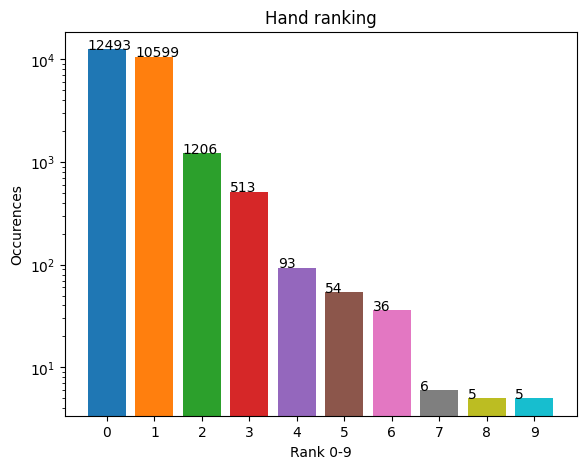

           prob_hand
Hand Rank           
0              49.95
1              42.37
2               4.82
3               2.05
4               0.37
5               0.21
6               0.14
7               0.02
8               0.01
9               0.01


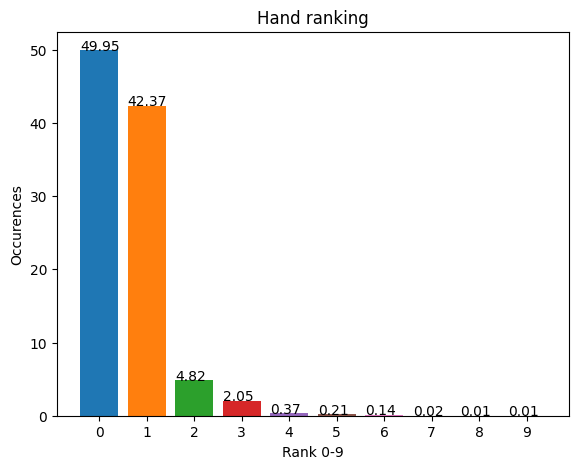

In [8]:
# vizualize the distribution of the possible hands in the train data.
print(y_train.groupby(y_train).size())
y = y_train.groupby(y_train).size()
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_title("Hand ranking")
ax.set_xlabel("Rank 0-9")
ax.set_ylabel("Occurences")
ax.set_yscale("log")
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
for val in range(len(y)):
    ax.annotate(str(y[val]), xy=(val, y[val]), xytext=(val - 0.4, y[val]))
    ax.bar(val, y[val])
plt.show()
hands = y.sum()
s = pd.DataFrame()
s["prob_hand"] = y.apply(lambda x: (x * 10000 // hands) / 100)
print(s)
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_title("Hand ranking")
ax.set_xlabel("Rank 0-9")
ax.set_ylabel("Occurences")
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
for val in range(len(s)):
    ax.annotate(
        str(s.iloc[val, 0]),
        xy=(val, s.iloc[val, 0]),
        xytext=(val - 0.4, s.iloc[val, 0]),
    )
    ax.bar(val, s.iloc[val, 0])
plt.show()

I found it interesting to explore the relationship between the occurrences and the probabilities of each possible hands. As you can see by the data, the majority of hand you will play during a session of poker are worth nothing. If you happen to have a pair, you can develop an appropriate betting strategy in order to see if you are able to cover anyone. Be concerned that although you have a relatively common hand, someone will always have a hand better than yours. If you happen to have a two pair and both cards of the pair are not found in the community cards. You have a relatively strong hand compared to others. The odds of being beat by a set exist, but as shown, it is relatively low compared to other hands. Good luck getting anything else, the odds for the rest are very low.

One thing to take into account, I did not create this data set and does not reflect probabilities during actual games. Just what is being observed based on the generated set. Although, these probabilities are useful for this task. Considering you are dealt a hand of 5.


# Step 4

Deciding on the proper model to use

Given the data, we know we will be using a classification model. I have chosen to compare the results between many model. It is always a good idea to test the score from several models in order to see which works best.
The method below helps us to determine which model to use by logging the model accuracy, F1, Precision and Recall.


In [ ]:

def get_model_log(model, xtest, ytest, model_name= 'model'):
    """
    Trains a machine learning model and evaluates its performance metrics.

    Args:
       model: The machine learning model to train and evaluate.
       xtest (pd.DataFrame): The testing data features.
       ytest (pd.Series): The testing data target labels.
       model_name (str, optional): The name of the model. Defaults to 'model'.

    Returns:
        pd.DataFrame: A DataFrame containing the model's performance metrics:
            - Accuracy
            - F1 score (weighted average)
            - Precision (weighted average)
            - Recall (weighted average)
    """


    y_pred = model.predict(xtest)
    if 'lstm' in model_name.lower():
      # Convert predictions to class labels
      print(f"LSTM pred probability: {y_pred}")
      y_pred = np.argmax(y_pred, axis=1)
      print(f"LSTM prediction hand: {y_pred}")

    model_log = pd.DataFrame(columns=["Accuracy", "F1", "Precision", "Recall"])
    model_log.loc[0, "Accuracy"] = accuracy_score(ytest, y_pred)
    model_log.loc[0, "F1"] = f1_score(ytest, y_pred, average="weighted")
    model_log.loc[0, "Precision"] = precision_score(ytest, y_pred, average="weighted")
    model_log.loc[0, "Recall"] = recall_score(ytest, y_pred, average="weighted")

    return model_log

# Step 5

## Using normal data without preprocessed for classification

- To learn about the Decision Tree model and Random Forest model goto: https://scikit-learn.org/stable/supervised_learning.html
- To learn about the XGBoost model: https://xgboost.readthedocs.io/en/stable/
- To learn about LSTM model: https://en.wikipedia.org/wiki/Long_short-term_memory

NOTE: This step will take some time to complete. Please be patient and check after some time.


In [ ]:
dt = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=1)
dt.fit(X_train, y_train)

dt_log = get_model_log(dt, X_test, y_test, model_name='dt')
dt_log

,Accuracy,F1,Precision,Recall
0,0.491785,0.488575,0.485669,0.491785


In [ ]:
xgb = XGBClassifier(learning_rate=0.3, n_estimators=10, max_depth=6)
xgb.fit(X_train, y_train)

xgb_log = get_model_log(xgb, X_test, y_test, model_name='xgb')
xgb_log

,Accuracy,F1,Precision,Recall
0,0.617402,0.58025,0.594356,0.617402


In [ ]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

rf_log = get_model_log(rf, X_test, y_test, model_name='rf')
rf_log

,Accuracy,F1,Precision,Recall
0,0.565899,0.537059,0.537977,0.565899


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical

# Assuming y_train and y_test are your target variables
y_train_encoded = to_categorical(y_train)

# Reshape the input data for LSTM
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build an LSTM model
lstm = Sequential()
lstm.add(LSTM(units=50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm.add(Dense(units=10, activation='softmax'))  # Assuming 10 classes (0 to 9)

# Compile the model
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm.fit(X_train_reshaped, y_train_encoded, epochs=2, batch_size=32, validation_split=0.2)

lstm_log = get_model_log(lstm, X_test_reshaped, y_test, model_name='lstm')
lstm_log


Epoch 1/2
626/626 [==============================] - 5s 5ms/step - loss: 1.0367 - accuracy: 0.5013 - val_loss: 0.9739 - val_accuracy: 0.5212
Epoch 2/2
31250/31250 [==============================] - 49s 2ms/step
LSTM pred probability: [[5.0538713e-01 4.0264860e-01 5.0362114e-02 ... 4.1457906e-04
  3.2838091e-04 6.8610726e-04]
 [5.2065527e-01 4.0686244e-01 4.8448753e-02 ... 2.1849817e-04
  1.9989233e-04 3.9231245e-04]
 [5.3161252e-01 3.9146563e-01 5.0265163e-02 ... 2.1616220e-04
  1.9390194e-04 4.0744612e-04]
 ...
 [4.0286577e-01 5.1761335e-01 5.3527094e-02 ... 2.0851263e-04
  1.6311496e-04 4.1270111e-04]
 [5.1262099e-01 4.0724266e-01 5.7040982e-02 ... 2.3989816e-04
  1.7647311e-04 3.2652402e-04]
 [5.2295053e-01 4.1411966e-01 3.5843346e-02 ... 2.5815197e-04
  2.0544398e-04 3.7012313e-04]]
LSTM prediction hand: [0 0 0 ... 1 0 0]


,Accuracy,F1,Precision,Recall
0,0.538492,0.47211,0.492342,0.538492


In [ ]:
result_df = pd.DataFrame(
    {
        "Model": ["DT", "XGB", "RF", "LSTM"],
        "Accuracy": [
            dt_log["Accuracy"].mean(),
            xgb_log["Accuracy"].mean(),
            rf_log["Accuracy"].mean(),
            lstm_log["Accuracy"].mean(),

        ],
        "F1": [
            dt_log["F1"].mean(),
            xgb_log["F1"].mean(),
            rf_log["F1"].mean(),
            lstm_log["F1"].mean(),

        ],
        "Precision": [
            dt_log["Precision"].mean(),
            xgb_log["Precision"].mean(),
            rf_log["Precision"].mean(),
            lstm_log["Precision"].mean(),
        ],
        "Recall": [
            dt_log["Recall"].mean(),
            xgb_log["Recall"].mean(),
            rf_log["Recall"].mean(),
            lstm_log["Recall"].mean(),
        ],
    }
)

result_df.head(8)

,Model,Accuracy,F1,Precision,Recall
0,DT,0.491785,0.488575,0.485669,0.491785
1,XGB,0.617402,0.580250,0.594356,0.617402
2,RF,0.565899,0.537059,0.537977,0.565899
3,LSTM,0.538492,0.472110,0.492342,0.538492


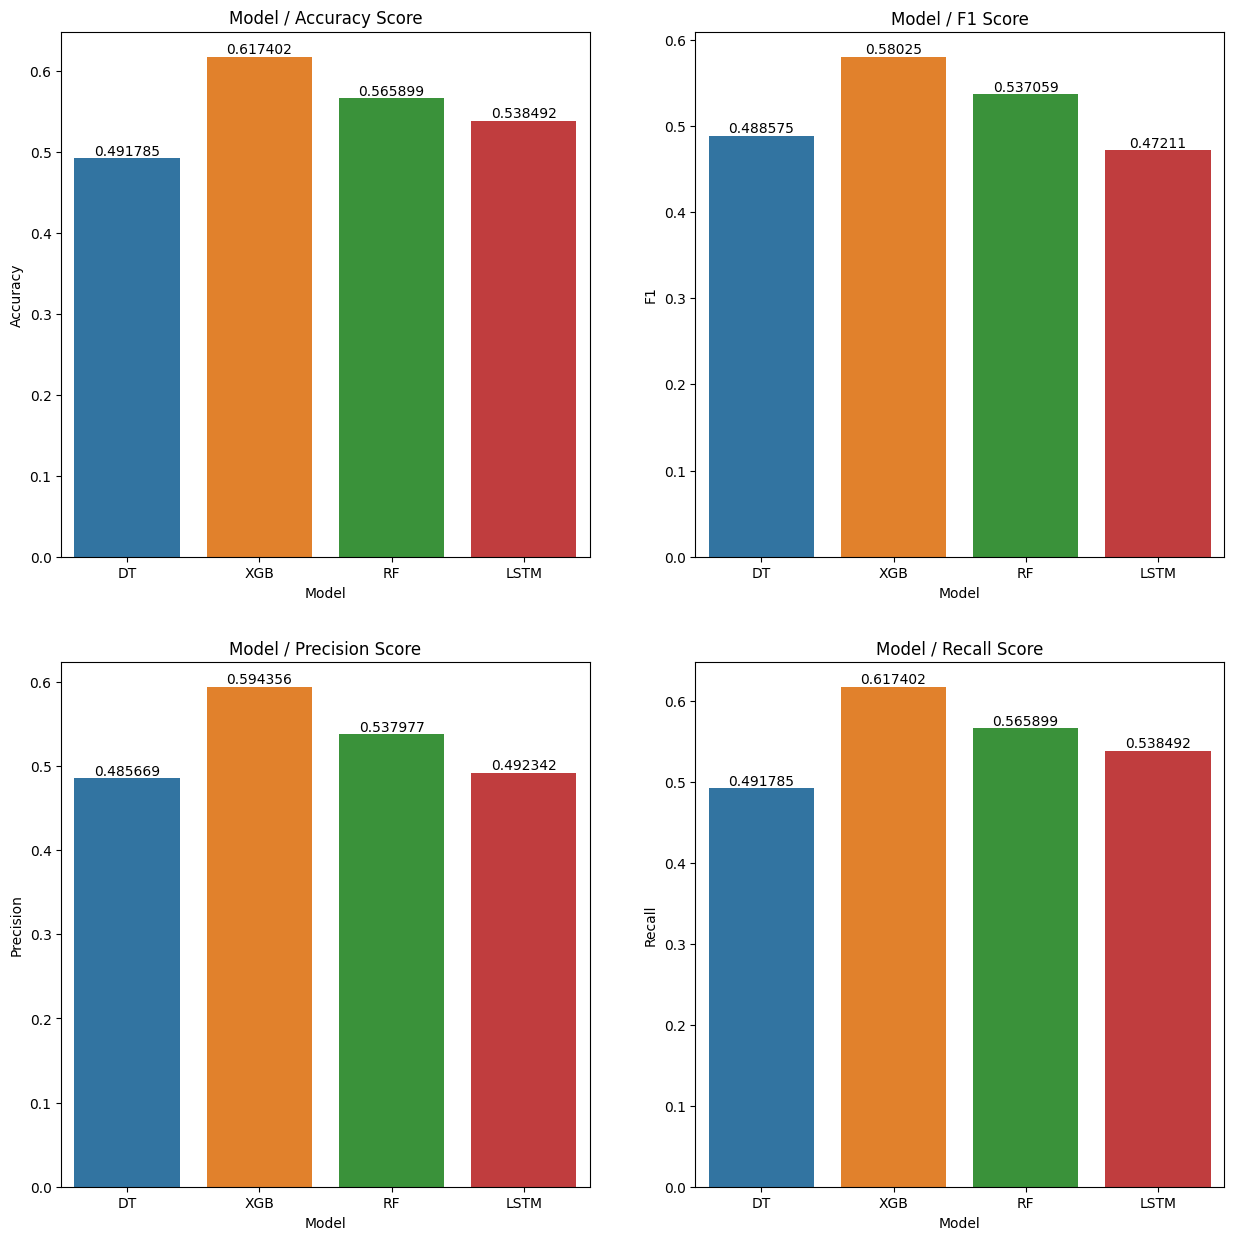

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
ax = sns.barplot(data=result_df, x="Model", y="Accuracy")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Accuracy Score")

plt.subplot(222)
ax = sns.barplot(data=result_df, x="Model", y="F1")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / F1 Score")

plt.subplot(223)
ax = sns.barplot(data=result_df, x="Model", y="Precision")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Precision Score")

plt.subplot(224)
ax = sns.barplot(data=result_df, x="Model", y="Recall")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Recall Score")

plt.show()

# Step 6

## Using the pre processed data for classification


We must now decide how to clean and explain the relationships between the cards.

Each classification of a hand has a different relationship attached to the cards. In order for our model to pick up on these patterns we must find a way to articulate it.

- For pairs, sets, and quads (2,3, and 4 of a kind) we must show the common occurrences in the hand.
- For straights we must show the difference between the cards in an ascending order.
- For flushes we must show the common occurrences in the suits of the hand.

In order to do this we must assign some helper functions to help clean up the data.

#### Preprocess TODO

#### TODO:// I have put a simple helper function here, please add some more functions that will give more robust results.

The whole cell below copy it in your `sample_player/utils_yourteamname/preprocess.py` for future use of preprocess step in prediction.


In [ ]:
# TODO:// Add a helper function
"""Helper class"""
import numpy as np


def add_unique_count(df):
    """The helper function is the add_unique_count function.
    This function accepts a DataFrame which is then broken into the suits.
    Then a lambda function is applied to each of the rows to check and see
    how many unique suits are in the hand.
    This helps for checking a flush condition or not. A flush will always have
    a unique count of "1" because all cards must be of the same suit.

    Adds a new column "unique_suit" to the given DataFrame,
   counting the number of unique suits present in each hand.

   This function is useful for checking for flush conditions,
   as a flush will always have a unique_count of 1 (all cards same suit).

   Args:
       df (pd.DataFrame): The DataFrame containing hand data with columns
           "S1", "S2", "S3", "S4", and "S5" representing card suits.

   Returns:
       pd.DataFrame: The updated DataFrame with an additional column
           "unique_suit" contains the number of unique suits in each hand.
    """
    tmp_suit = df[["S1", "S2", "S3", "S4", "S5"]]
    df["unique_suit"] = tmp_suit.apply(lambda s: len(np.unique(s)), axis=1)
    return df


def pre_process_data(data):
    """First, we have to clean up the data to prepare to calculate the
    relationships mentioned above. Here we are taking the data splitting
    it up based on card and suit. We will then sort the values before
    combining it back into one DataFrame and passing onto the next helper
    function that will add relationships to the data frame.

    Preprocesses the hand data to prepare for relationship calculations.

   1. Sorts card ranks and suits separately for easier comparison.
   2. Reorders columns for intuitive analysis.
   3. Adds the "unique_suit" column to aid in flush detection.

   Args:
       data (pd.DataFrame): The DataFrame containing hand data with columns
           "C1", "C2", "C3", "C4", "C5" for card ranks and
           "S1", "S2", "S3", "S4", "S5" for card suits.

   Returns:
       pd.DataFrame: The preprocessed DataFrame with sorted cards and suits,
           reordered columns, and the "unique_suit" column added.
    """
    df = data.copy()
    cards = df[["C1", "C2", "C3", "C4", "C5"]]
    suits = df[["S1", "S2", "S3", "S4", "S5"]]
    cards.values.sort()
    suits.values.sort()
    df[["C1", "C2", "C3", "C4", "C5"]] = cards
    df[["S1", "S2", "S3", "S4", "S5"]] = suits
    df = df[["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5"]]

    df = add_unique_count(df)

    return df

After preprocessing the data save it in `content/data/processed_data/X_train_pre.csv` so that you can directly use the preprocessed data rather than wasting time again do it.


NOTE: This step will take some time to complete. Please be patient and check after some time.


In [ ]:
X_train_pre = pre_process_data(X_train)
X_train_pre.to_csv(f"{data_path}/processed_data/X_train_pre.csv")
X_train_pre = pd.read_csv(f"{data_path}/processed_data/X_train_pre.csv")
X_train_pre.head(5)

,Unnamed: 0,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,0,1,1,1,10,1,11,1,12,1,13,1
1,1,2,1,2,10,2,11,2,12,2,13,1
2,2,3,1,3,10,3,11,3,12,3,13,1
3,3,4,1,4,10,4,11,4,12,4,13,1
4,4,4,1,4,10,4,11,4,12,4,13,1


### Removing unwanted columns


In [ ]:
X_train_pre.drop("Unnamed: 0", axis=1, inplace=True)

X_train_pre.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,1,1,1,10,1,11,1,12,1,13,1
1,2,1,2,10,2,11,2,12,2,13,1
2,3,1,3,10,3,11,3,12,3,13,1
3,4,1,4,10,4,11,4,12,4,13,1
4,4,1,4,10,4,11,4,12,4,13,1


Comment the lines after preprocessing done once to save time next time by reusing the preprocessed data.


In [ ]:
X_test_pre = pre_process_data(
    X_test
)  # Comment this line after preprocessing done once to save time next time
X_test_pre.to_csv(
    f"{data_path}/processed_data/X_test_pre.csv"
)  # Comment this line after preprocessing done once to save time next time
X_test_pre = pd.read_csv(f"{data_path}/processed_data/X_test_pre.csv")
X_test_pre.head(5)

,Unnamed: 0,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,0,1,1,1,3,1,4,2,12,2,13,2
1,1,2,2,3,5,3,5,3,11,4,12,3
2,2,1,2,1,4,3,6,3,9,4,9,3
3,3,1,1,2,4,2,6,3,13,3,13,3
4,4,1,2,2,7,2,9,3,10,4,11,4


In [ ]:
X_test_pre.drop("Unnamed: 0", axis=1, inplace=True)

X_test_pre.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,1,1,1,3,1,4,2,12,2,13,2
1,2,2,3,5,3,5,3,11,4,12,3
2,1,2,1,4,3,6,3,9,4,9,3
3,1,1,2,4,2,6,3,13,3,13,3
4,1,2,2,7,2,9,3,10,4,11,4


#### TODO:// Here for all the models I have used vanilla model with default parameters, you can play around with the parameters and get the best results

For parameter information please visit:

- To learn about the Decision Tree model and Random Forest model goto: https://scikit-learn.org/stable/supervised_learning.html
- To learn about the XGBoost model: https://xgboost.readthedocs.io/en/stable/
- To learn about the LSTM: https://keras.io/api/layers/recurrent_layers/lstm/

NOTE: This step will take some time to complete. Please be patient and check after some time.


In [ ]:
# TODO: Add parameters
dt2 = DecisionTreeClassifier(min_samples_split=20, min_samples_leaf=1)
dt2.fit(X_train_pre, y_train)

dt_log2 = get_model_log(dt2, X_test_pre, y_test, model_name='dt2')
dt_log2

,Accuracy,F1,Precision,Recall
0,0.951701,0.948875,0.948059,0.951701


In [ ]:
xgb2 = XGBClassifier(learning_rate=0.3, n_estimators=1, max_depth=2)
xgb2.fit(X_train_pre, y_train)

xgb_log2 = get_model_log(xgb2, X_test_pre, y_test, model_name='xgb2')
xgb_log2

,Accuracy,F1,Precision,Recall
0,0.571241,0.471387,0.642013,0.571241


In [ ]:
rf2 = RandomForestClassifier(n_estimators=1)
rf2.fit(X_train_pre, y_train)

rf_log2 = get_model_log(rf2, X_test_pre, y_test, model_name='rf2')
rf_log2

,Accuracy,F1,Precision,Recall
0,0.839558,0.836824,0.835307,0.839558


In [ ]:
# Assuming y_train and y_test are your target variables
y_train_encoded = to_categorical(y_train)

# Reshape the input data for LSTM
X_train_pre_reshaped = X_train_pre.values.reshape(X_train_pre.shape[0], 1, X_train_pre.shape[1])
X_test_pre_reshaped = X_test_pre.values.reshape(X_test_pre.shape[0], 1, X_test_pre.shape[1])

# Build an LSTM model
lstm2 = Sequential()
lstm2.add(LSTM(units=50, input_shape=(X_train_pre_reshaped.shape[1], X_train_pre_reshaped.shape[2])))
lstm2.add(Dense(units=10, activation='softmax'))  # Assuming 10 classes (0 to 9)

# Compile the model
lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm2.fit(X_train_pre_reshaped, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

lstm2_log = get_model_log(lstm2, X_test_pre_reshaped, y_test, model_name='lstm')
lstm2_log

Epoch 1/5
626/626 [==============================] - 4s 4ms/step - loss: 0.9761 - accuracy: 0.5695 - val_loss: 0.8701 - val_accuracy: 0.5992
Epoch 2/5
626/626 [==============================] - 2s 4ms/step - loss: 0.8381 - accuracy: 0.6329 - val_loss: 0.7904 - val_accuracy: 0.6639
Epoch 3/5
626/626 [==============================] - 2s 4ms/step - loss: 0.7672 - accuracy: 0.6763 - val_loss: 0.7280 - val_accuracy: 0.6891
Epoch 4/5
626/626 [==============================] - 2s 4ms/step - loss: 0.7077 - accuracy: 0.7039 - val_loss: 0.6956 - val_accuracy: 0.6907
Epoch 5/5
31250/31250 [==============================] - 50s 2ms/step
LSTM pred probability: [[5.43436527e-01 3.96253586e-01 4.26198840e-02 ... 1.15965944e-04
  4.73637891e-04 3.81444988e-04]
 [4.92806405e-01 4.56251085e-01 4.08682376e-02 ... 4.83037766e-05
  2.11244755e-04 1.28180458e-04]
 [6.49208069e-01 3.14661652e-01 2.97094975e-02 ... 4.10164357e-05
  1.13271184e-04 9.10743038e-05]
 ...
 [2.28709370e-01 5.54821193e-01 1.9417782

,Accuracy,F1,Precision,Recall
0,0.741908,0.719542,0.730902,0.741908


# Results


In [ ]:
result_df = pd.DataFrame(
    {
        "Model": ["DT", "XGB", "RF", "LSTM", "DT2", "XGB2", "RF2", "LSTM2"],
        "Accuracy": [
            dt_log["Accuracy"].mean(),
            xgb_log["Accuracy"].mean(),
            rf_log["Accuracy"].mean(),
            lstm_log["Accuracy"].mean(),
            dt_log2["Accuracy"].mean(),
            xgb_log2["Accuracy"].mean(),
            rf_log2["Accuracy"].mean(),
            lstm2_log["Accuracy"].mean(),

        ],
        "F1": [
            dt_log["F1"].mean(),
            xgb_log["F1"].mean(),
            rf_log["F1"].mean(),
            lstm_log["F1"].mean(),
            dt_log2["F1"].mean(),
            xgb_log2["F1"].mean(),
            rf_log2["F1"].mean(),
            lstm2_log["F1"].mean(),

        ],
        "Precision": [
            dt_log["Precision"].mean(),
            xgb_log["Precision"].mean(),
            rf_log["Precision"].mean(),
            lstm_log["Precision"].mean(),
            dt_log2["Precision"].mean(),
            xgb_log2["Precision"].mean(),
            rf_log2["Precision"].mean(),
            lstm2_log["Precision"].mean(),
        ],
        "Recall": [
            dt_log["Recall"].mean(),
            xgb_log["Recall"].mean(),
            rf_log["Recall"].mean(),
            lstm_log["Recall"].mean(),
            dt_log2["Recall"].mean(),
            xgb_log2["Recall"].mean(),
            rf_log2["Recall"].mean(),
            lstm2_log["Recall"].mean(),
        ],
    }
)

result_df.head(8)

,Model,Accuracy,F1,Precision,Recall
0,DT,0.491785,0.488575,0.485669,0.491785
1,XGB,0.617402,0.580250,0.594356,0.617402
2,RF,0.565899,0.537059,0.537977,0.565899
3,LSTM,0.538492,0.472110,0.492342,0.538492
4,DT2,0.951701,0.948875,0.948059,0.951701
5,XGB2,0.571241,0.471387,0.642013,0.571241
6,RF2,0.839558,0.836824,0.835307,0.839558
7,LSTM2,0.741908,0.719542,0.730902,0.741908


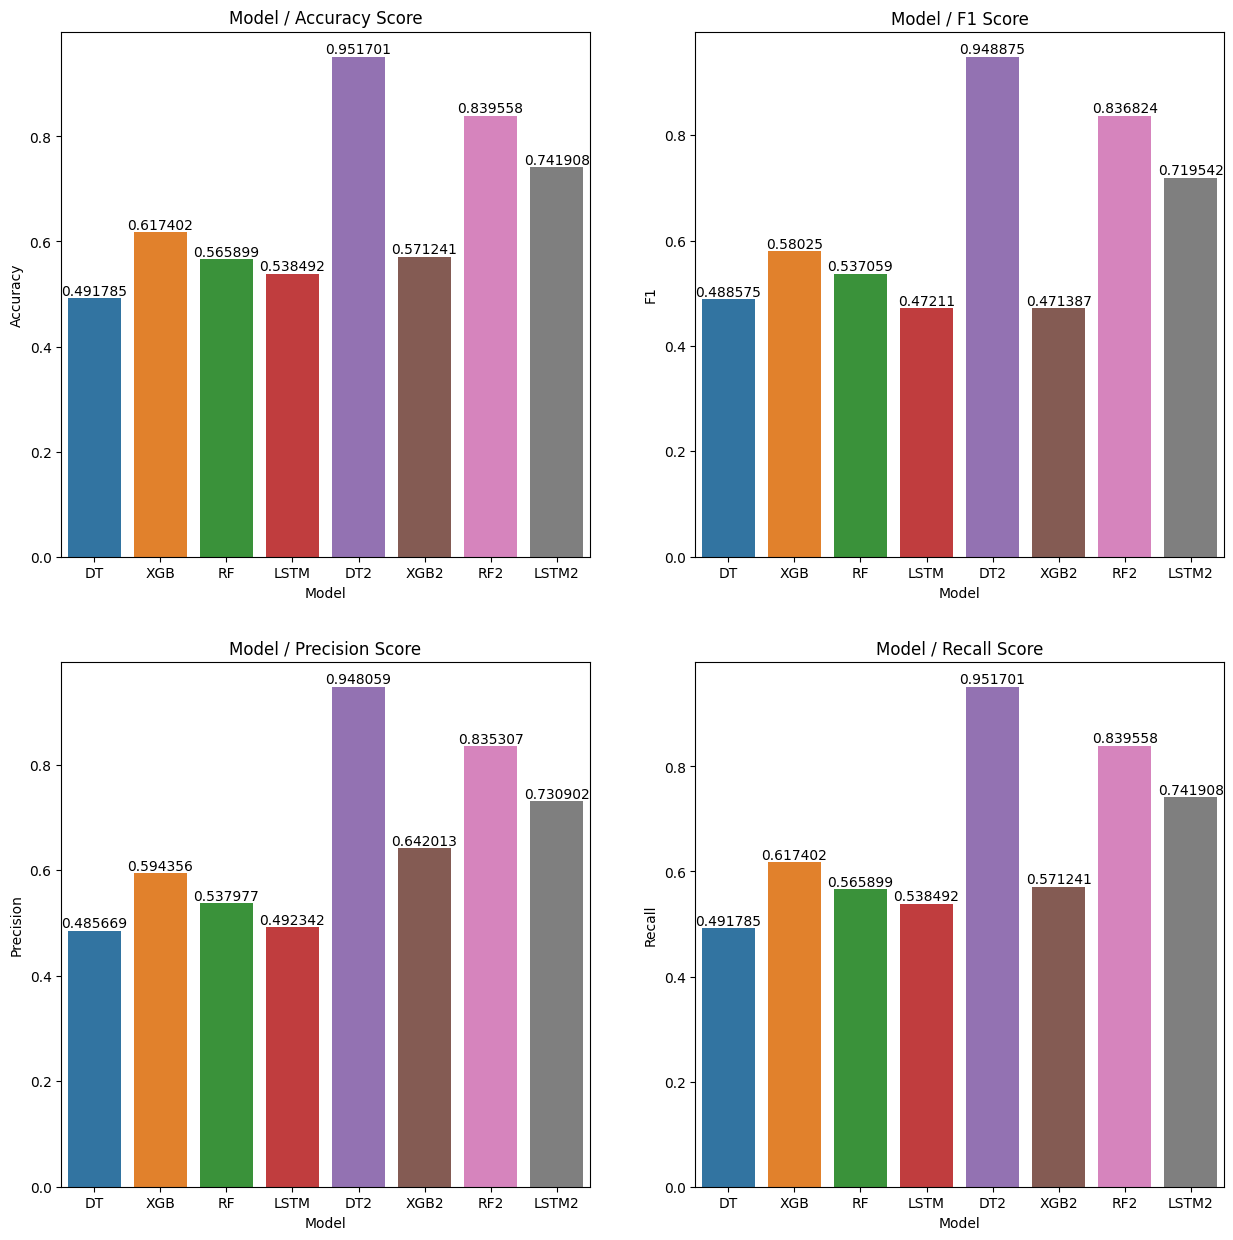

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
ax = sns.barplot(data=result_df, x="Model", y="Accuracy")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Accuracy Score")

plt.subplot(222)
ax = sns.barplot(data=result_df, x="Model", y="F1")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / F1 Score")

plt.subplot(223)
ax = sns.barplot(data=result_df, x="Model", y="Precision")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Precision Score")

plt.subplot(224)
ax = sns.barplot(data=result_df, x="Model", y="Recall")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Recall Score")

plt.show()

### Save the model


Save the model and change your team name.

Save your model in pkl format only.


In [ ]:
import pickle

model_path = f"{root}/model/saved_model_teamACN.pkl"

with open(model_path, "wb") as file:
    pickle.dump(dt2, file)

### Load the model and test it


Method to load the model and model_input (list): A list of numerical values representing the poker hand features.


In [ ]:
def get_best_hand(
    model_input,
    model_file_path=f"{root}/model/saved_model_teamACN.pkl",
    model_name="model",
):
    """
    Predicts the best poker hand category for a given set of model inputs using a pre-trained model.

    Args:
        model_input (list): A list of numerical values representing the poker hand features.
            The values should be in the order of [S1, C1, S2, C2, S3, C3, S4, C4, S5, C5],
            where Sx represents suit and Cx represents rank.
        model_file_path (str, optional): The file path to the pickled model file. Default is the path
            to the pre-trained model file.
       model_name (str, optional): The name of the model. Defaults to 'model'.

    Returns:
        int: The predicted poker hand category.
    """

    # Load the model from the pickled file
    with open(model_file_path, "rb") as file:
        loaded_model = pickle.load(file)

    # Now 'loaded_model' contains the model loaded from the pickled file
    column_names = ["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5"]

    df_model_input = pd.DataFrame([model_input], columns=column_names)

    x = pre_process_data(df_model_input)
    if 'lstm' in model_name.lower():
        # Assuming model_input has shape (batch_size, num_features)
        x_reshaped = np.expand_dims(x, axis=1)
        y_pred = loaded_model.predict(x_reshaped)
        # Get the index of the maximum probability
        predicted_class = np.argmax(y_pred)
        return [predicted_class]

    y_pred = loaded_model.predict(x)
    return y_pred

Create model input if the cards are in the form like `["CK", "C6","C7", "C8", "C9"]` to model recognisable format `` .


In [ ]:
def get_model_input(cards) -> list:
    """
    Converts a list of poker cards into a numerical representation based on suit and rank.

    Parameters:
    - cards (list of str): A list of strings representing poker cards (e.g., ['H4', 'DQ']).

    Returns:
    list: A list of numerical values representing the poker cards based on suit and rank.

    Raises:
    None
    """
    suit_mapping = {"H": 1, "S": 2, "D": 3, "C": 4}
    rank_mapping = {
        "A": 1,
        "2": 2,
        "3": 3,
        "4": 4,
        "5": 5,
        "6": 6,
        "7": 7,
        "8": 8,
        "9": 9,
        "T": 10,
        "J": 11,
        "Q": 12,
        "K": 13,
    }

    # Combine dictionaries using the update method
    char_mapping = {}
    char_mapping.update(suit_mapping)
    char_mapping.update(rank_mapping)

    model_input = []

    for card in cards:
        for char in list(card):
            model_input.append(char_mapping[char])

    return model_input

### Model output

Using the methods above we can predict the outcome of the best hand in cards.


In [ ]:
cards = ["H6", "C6", "C7", "C8", "C9"]
model_input = get_model_input(cards)
print(f"Model Input for {cards}: {model_input}")
model_output = get_best_hand(model_input, model_path, model_name='dt2')
print(f"Best hand: {model_output[0]}")

Model Input for ['H6', 'C6', 'C7', 'C8', 'C9']: [1, 6, 4, 6, 4, 7, 4, 8, 4, 9]
Best hand: 1


# Conclusion

As you can see DT2 have at least 95% accuracy in it's prediction, so I choose to save this model for future use.

Given the results, we can conclude that we can accurately predict the given poker hand. The next steps would be adding this model to create the strategy for fold rounds.
